In [1]:
library(tidyr)
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
similarity <- read.csv('../../interneuron-reward-data/processed/mean_fluo_df.csv')

# Convert numeric cell_id to factor
similarity[, 'day'] <- as.factor(similarity[, 'day'])
similarity[, 'cell_id'] <- as.factor(similarity[, 'cell_id'])

# Display first few rows
head(similarity)

day,cell_type,cell_id,mouse_id,tone.fluo,tone...delay.fluo,reward.fluo,tone,tone...delay,reward
1,vip,3121,CL136,0.006833030,-0.006349484,-0.01529785,-0.04264971,-0.08960109,-0.11040496
7,vip,3121,CL136,0.056055617,0.292485240,0.06468096,-0.20564170,-0.02291315,-0.32023506
1,vip,3122,CL136,0.078296930,0.026572336,-0.12282959,0.11017130,0.04822452,-0.31156678
7,vip,3122,CL136,-0.027617505,-0.061786220,0.21803150,-0.24034267,-0.42962872,-0.05429231
1,vip,3123,CL136,-0.002097508,0.013349945,0.03203164,-0.06273525,-0.04521951,-0.02233526
7,vip,3123,CL136,-0.058398563,-0.018949620,-0.02196498,-0.06965835,-0.04938029,-0.04319692


In [3]:
similarity_long <- similarity %>% gather("trial_component", 'tuning', 'tone...delay', 'reward')
similarity_long <- subset(
    similarity_long, select=c('day', 'cell_type', 'cell_id', 'mouse_id', 'trial_component', 'tuning'))
head(similarity_long)

day,cell_type,cell_id,mouse_id,trial_component,tuning
1,vip,3121,CL136,tone...delay,-0.08960109
7,vip,3121,CL136,tone...delay,-0.02291315
1,vip,3122,CL136,tone...delay,0.04822452
7,vip,3122,CL136,tone...delay,-0.42962872
1,vip,3123,CL136,tone...delay,-0.04521951
7,vip,3123,CL136,tone...delay,-0.04938029


In [4]:
similarity_long$trial_component[similarity_long$trial_component == 'tone...delay'] <- 'Tone'
similarity_long$trial_component[similarity_long$trial_component == 'reward'] <- 'Reward'
similarity_long$trial_component <- factor(similarity_long$trial_component, levels=c('Tone', 'Reward'))

similarity_long$cell_type <- factor(sapply(similarity_long$cell_type, toupper), levels=c('PYR', 'VIP', 'PV', 'SOM'))

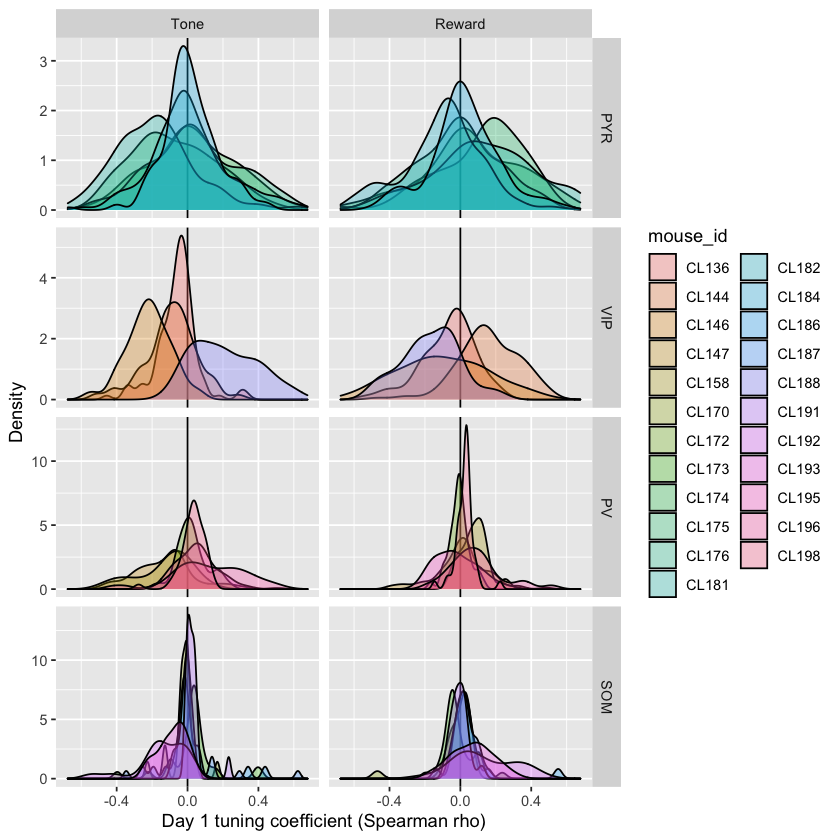

In [5]:
per_mouse_similarity <- (
    ggplot(
        similarity_long[similarity_long$day == 1, ], 
        aes(x=tuning, fill=mouse_id)
    )
    + facet_grid(rows=vars(cell_type), cols=vars(trial_component), scales='free_y')
    + geom_vline(xintercept=0)
    + geom_density(alpha=0.3)
    + labs(y='Density', x='Day 1 tuning coefficient (Spearman rho)')
)

ggsave(file='../img/graphics/per_mouse_similarity_day1.svg', plot=per_mouse_similarity, width=6, height=6)

per_mouse_similarity

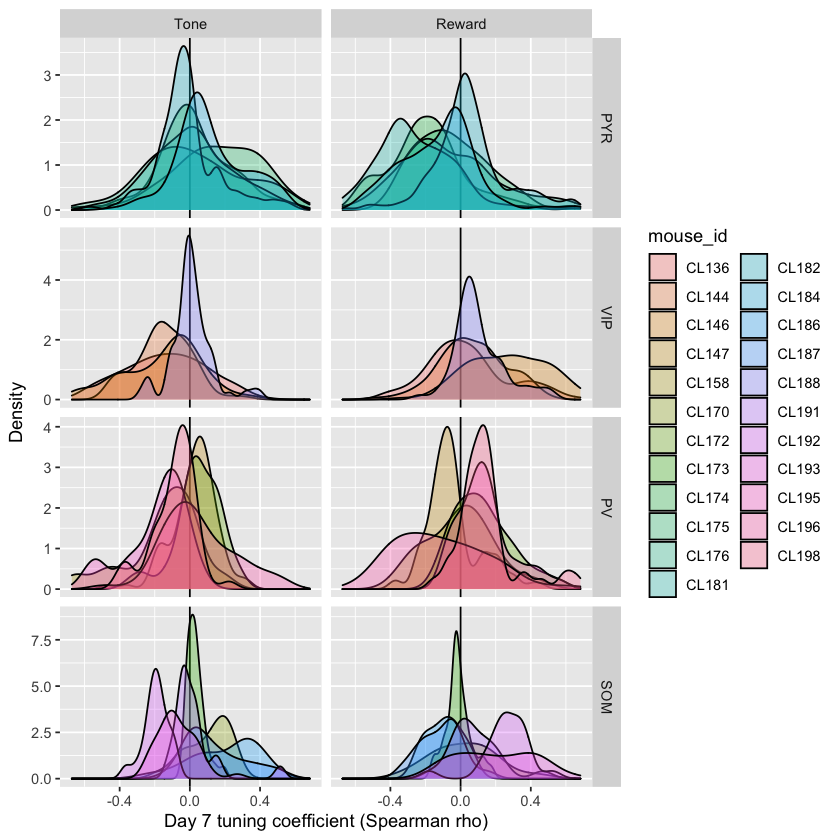

In [6]:
per_mouse_similarity <- (
    ggplot(
        similarity_long[similarity_long$day == 7, ], 
        aes(x=tuning, fill=mouse_id)
    )
    + facet_grid(rows=vars(cell_type), cols=vars(trial_component), scales='free_y')
    + geom_vline(xintercept=0)
    + geom_density(alpha=0.3)
    + labs(y='Density', x='Day 7 tuning coefficient (Spearman rho)')
)

ggsave(file='../img/graphics/per_mouse_similarity_day7.svg', plot=per_mouse_similarity, width=6, height=6)

per_mouse_similarity

In [7]:
difference_dfs <- list()

for (response_variable in c('reward', 'tone...delay')) {
    difference <- (
        similarity[, c('day', 'cell_id', 'cell_type', 'mouse_id', response_variable)] 
        %>% spread(day, response_variable)
    )
    difference[, 'tuning_change'] <- difference[,"7"] - difference[,"1"]
    difference <- difference[, !(colnames(difference) %in% c("1", "7"))]
    
    difference_dfs[[response_variable]] <- difference
}

In [8]:
difference_dfs[['reward']][, 'trial_component'] <- 'Reward tuning'
difference_dfs[['tone...delay']][, 'trial_component'] <- 'Tone tuning'


difference <- rbind(
    difference_dfs[['reward']], 
    difference_dfs[['tone...delay']]
)
head(difference)

cell_id,cell_type,mouse_id,tuning_change,trial_component
1,pyr,CL174,-0.1041927,Reward tuning
2,pyr,CL174,0.1412351,Reward tuning
3,pyr,CL174,-0.5789253,Reward tuning
4,pyr,CL174,-0.1445291,Reward tuning
5,pyr,CL174,0.5753425,Reward tuning
6,pyr,CL174,0.5649983,Reward tuning


In [9]:
summary(difference)

    cell_id     cell_type     mouse_id    tuning_change      
 1      :   2   pv : 624   CL176  : 598   Min.   :-1.247365  
 2      :   2   pyr:2414   CL182  : 510   1st Qu.:-0.202765  
 3      :   2   som: 378   CL174  : 422   Median :-0.002803  
 4      :   2   vip: 814   CL184  : 372   Mean   :-0.008332  
 5      :   2              CL181  : 366   3rd Qu.: 0.186137  
 6      :   2              CL136  : 240   Max.   : 1.133464  
 (Other):4218              (Other):1722   NA's   :2          
 trial_component   
 Length:4230       
 Class :character  
 Mode  :character  
                   
                   
                   
                   

In [10]:
difference$trial_component <- factor(difference$trial_component, levels=c('Tone tuning', 'Reward tuning'))
difference$cell_type <- factor(sapply(difference$cell_type, toupper), levels=c('PYR', 'VIP', 'PV', 'SOM'))

Warning message:
“Removed 2 rows containing non-finite values (stat_density).”Warning message:
“Removed 2 rows containing non-finite values (stat_density).”

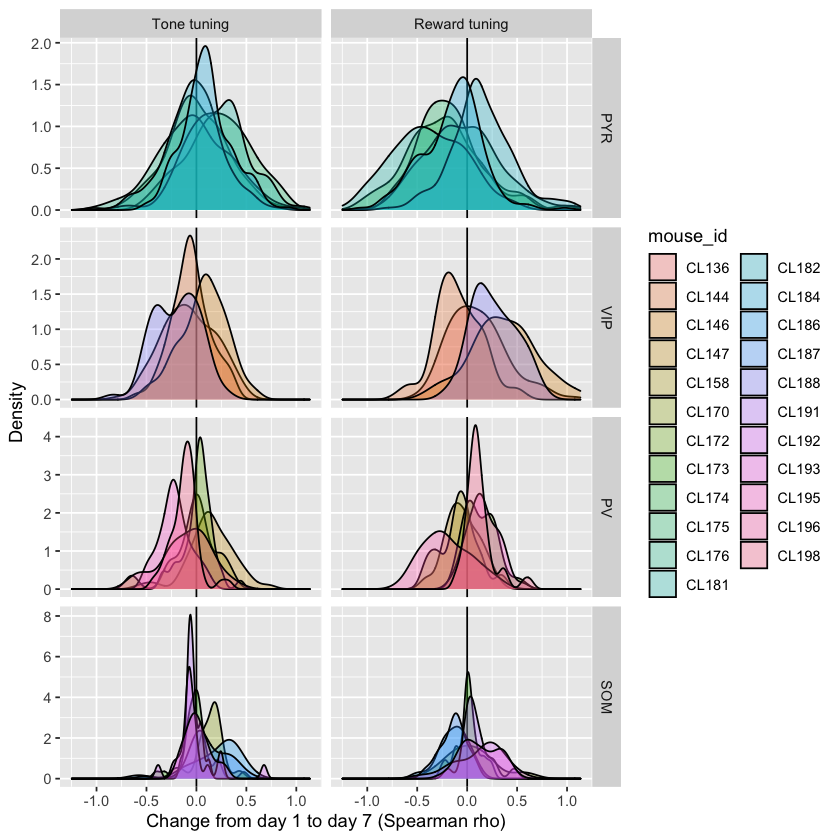

In [11]:
per_mouse_similarity_change <- (
    ggplot(difference, aes(x=tuning_change, fill=mouse_id))
    + facet_grid(rows=vars(cell_type), cols=vars(trial_component), scales='free_y')
    + geom_vline(xintercept=0)
    + geom_density(alpha=0.3)
    + labs(y='Density', x='Change from day 1 to day 7 (Spearman rho)')
)

ggsave(file='../img/graphics/per_mouse_similarity_change.svg', plot=per_mouse_similarity_change, width=6, height=6)

per_mouse_similarity_change